# Measurements & Tests in SCION

## Initializing the slice and the nodes

In [1]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager()
fablib.show_config();

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Project ID,488bd68e-9703-447b-bd77-069da4f438a6
Token File,/home/fabric/.tokens.json
Bastion Host,bastion.fabric-testbed.net
Bastion Username,shams_gozalova_nl_0000148275
Bastion Private Key File,/home/fabric/work/fabric_config/BastionKeyShamsRP1
Slice Private Key File,/home/fabric/work/fabric_config/SliverKeyShamsRP1
Slice Public Key File,/home/fabric/work/fabric_config/SliverKeyShamsRP1.pub
Log File,/tmp/fablib/fablib.log
Log Level,INFO


In [2]:
slice_name = 'SCION_ISD42'
# naming nodes
node1_name = 'scion01'
node2_name = 'scion02'
node3_name = 'scion03'
node4_name = 'scion04'
node5_name = 'scion05'
# creating l2 networks
network_name12='net12'
network_name14='net14'
network_name13='net13'
network_name23='net23'
network_name25='net25'
network_name34='net34'
network_name35='net35'
# namic NICs
node1a_nic_name = 'nic1a'
node1b_nic_name = 'nic1b'
node1c_nic_name = 'nic1c'
node2a_nic_name = 'nic2a'
node2b_nic_name = 'nic2b'
node2c_nic_name = 'nic2c'
node3a_nic_name = 'nic3a'
node3b_nic_name = 'nic3b'
node3c_nic_name = 'nic3c'
node3d_nic_name = 'nic3d'
node4a_nic_name = 'nic4a'
node4b_nic_name = 'nic4b'
node5a_nic_name = 'nic5a'
node5b_nic_name = 'nic5b'

In [3]:
slice = fablib.get_slice(name=slice_name)
##get the nodes
node1 = slice.get_node(name=node1_name)
node2 = slice.get_node(name=node2_name)
node3 = slice.get_node(name=node3_name)
node4 = slice.get_node(name=node4_name)
node5 = slice.get_node(name=node5_name)

nodes = [node1, node2, node3, node4, node5]

## Latency measurement
measuring using scion ping

perform 10 pings from node1 to all nodes
put output in a file
take mean value of time
make histogram from all the results

MVP:
PING one time each node
use different paths
take ping time
put in file

In [4]:
node1.execute(f'echo 0 | /usr/local/scion/scion ping -c 1 42-ffaa:1:2,127.0.0.1 -i  >> ping_node1.log 2>&1')

('', '')

In [9]:
stdout, stderr = node1.execute(f"cat ping_node1.log | grep 'time=' | awk -F'time=' '{{print $2}}' | awk -F'ms' '{{print $1}}'")

69.094


In [8]:
stdout, stderr = node1.execute(f"cat ping_node1.log | grep -oP 'time=' | awk -F'=' '{{print $2}}' | awk -F'ms' '{{print $1}}'")

In [57]:
# printing number of hops
final_data = []
for node in nodes:
    node1.execute("rm ping_node1.log")
    if node == node1:
        continue
    print("printing scion address")
    stdout, stderr = node.execute("/usr/local/scion/scion address")
    AS_NUMBER = stdout.split(',')[0]
    print("available paths")
    stdout, stderr = node1.execute(f"/usr/local/scion/scion showpaths {AS_NUMBER} | grep 'Status' | awk -F'Hops: | MTU:' '{{print $2}}'")
    paths_to_node = stdout.splitlines()
    path_no = len(stdout.splitlines())

    # counting number of hops in each path
    hop_counts = []
    for line in paths_to_node:
        hop_counts.append(line.count('>') + 1)
        
    # pinging with different paths
    print(f"pinging with different paths to node {AS_NUMBER}")
    for i in range(path_no):
        node1.execute(f'echo {i} | /usr/local/scion/scion ping -c 1 {AS_NUMBER},127.0.0.1 -i  >> ping_node1.log 2>&1')
    
    # getting values of pings from different paths
    stdout, stderr = node1.execute(f"cat ping_node1.log | grep 'time=' | awk -F'time=' '{{print $2}}' | awk -F'ms' '{{print $1}}'")
    #times = stdout.splitlines()
    times = [float(item) for item in stdout.splitlines()]
    
    as_name_array = []
    for i in range (path_no):
        as_name_array.append(AS_NUMBER)
    
    data = list(zip(as_name_array, hop_counts, paths_to_node, times))
    final_data.append(data)
final_data = [list(tup) for sublist in final_data for tup in sublist]

 rm: cannot remove 'ping_node1.log': No such file or directory
 printing scion address
42-ffaa:1:2,127.0.0.1
available paths
[42-ffaa:1:1 2>1 42-ffaa:1:2]
[42-ffaa:1:1 3>1 42-ffaa:1:3 2>2 42-ffaa:1:2]
pinging with different paths to node 42-ffaa:1:2
69.508
69.384
printing scion address
42-ffaa:1:3,127.0.0.1
available paths
[42-ffaa:1:1 3>1 42-ffaa:1:3]
[42-ffaa:1:1 2>1 42-ffaa:1:2 2>2 42-ffaa:1:3]
pinging with different paths to node 42-ffaa:1:3
24.362
115.179
printing scion address
42-ffaa:1:4,127.0.0.1
available paths
[42-ffaa:1:1 1>1 42-ffaa:1:4]
[42-ffaa:1:1 3>1 42-ffaa:1:3 3>2 42-ffaa:1:4]
[42-ffaa:1:1 2>1 42-ffaa:1:2 2>2 42-ffaa:1:3 3>2 42-ffaa:1:4]
pinging with different paths to node 42-ffaa:1:4
22.010
61.114
152.680
printing scion address
42-ffaa:1:5,127.0.0.1
available paths
[42-ffaa:1:1 2>1 42-ffaa:1:2 3>1 42-ffaa:1:5]
[42-ffaa:1:1 3>1 42-ffaa:1:3 4>2 42-ffaa:1:5]
[42-ffaa:1:1 2>1 42-ffaa:1:2 2>2 42-ffaa:1:3 4>2 42-ffaa:1:5]
[42-ffaa:1:1 3>1 42-ffaa:1:3 2>2 42-ffaa:1:2 3>1 4

In [58]:
id = 1
for line in final_data:
    line.insert(0, id)
    id += 1

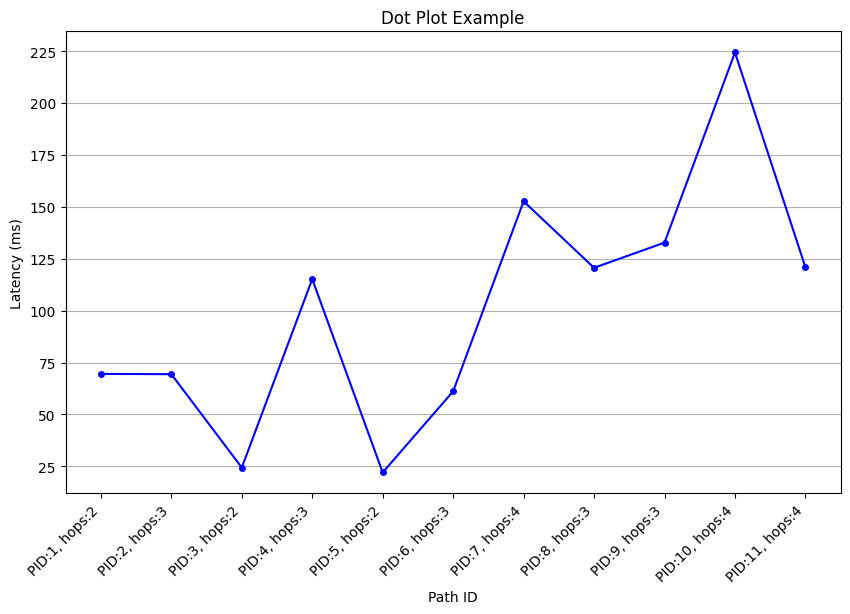

In [119]:
import matplotlib.pyplot as plt
latencies = []
path_id = []
# hop_count = []
i = 1
for line in final_data:
    latencies.append(line[4])
    # hop_count.append(line[2])
    path_id.append(f"PID:{i}, hops:{line[2]}")
    i += 1

# Example data
paths = path_id
latencies = latencies

plt.figure(figsize=(10, 6))

# Create a dot plot
plt.plot(paths, latencies, marker='o', linestyle='-', markersize=4, color='blue')

# Display actual values near the dots
# for paths, latency in zip(paths, latencies):
#     plt.text(paths, latency, str(latency), ha='center', va='top', fontsize=6)

# Add labels and title
plt.xlabel('Path ID')
plt.ylabel('Latency (ms)')
plt.title('Dot Plot Example')
plt.xticks(paths, rotation=45, ha='right')
plt.grid(axis='y')

# Show the plot
plt.show()


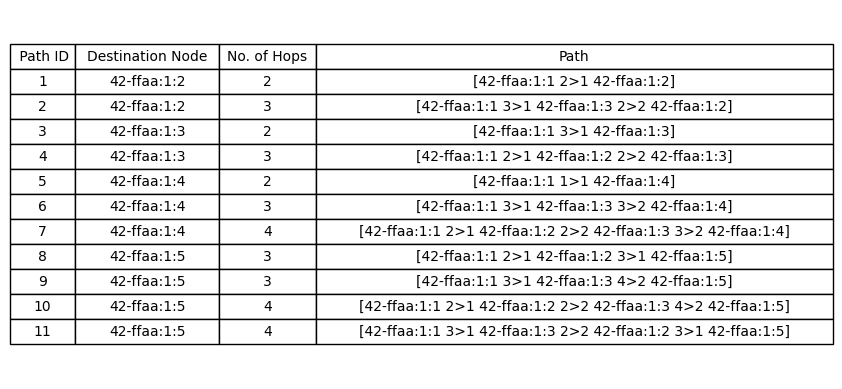

In [71]:
## generating table displaying the paths IDs and path segments

import matplotlib.pyplot as plt
import pandas as pd

# Example data
data = final_data

# Convert data to a Pandas DataFrame
df = pd.DataFrame(data, columns=[' Path ID', 'Destination Node', 'No. of Hops', 'Path', 'Latency, ms'])
df = df.drop(columns=['Latency, ms'])

# Plotting the table
fig, ax = plt.subplots()  # Adjust the figure size as needed
ax.axis('off')  # Turn off the axis

# Create a table
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# Customize the appearance of the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0, 1, 2, 3, 4])
table.scale(1, 1.5)

# Show the plot
plt.show()


In [99]:
## generaing plot and displaying plot or ping mean

# pinging node 2 from node 1 with each path 10 times
# sorting the values of latency
# displayin results
latency_variation2 = []
path_ids_variation2 = []
path_number2 = 0
node1.execute("rm ping_node2.log")
for line in final_data:
    if line[1] == '42-ffaa:1:2':
        path_number2 += 1
        path_ids_variation2.append(line[0])
        
# pinging with different paths
for i in range(path_number2):
    node1.execute(f'echo {i} | /usr/local/scion/scion ping -c 10 42-ffaa:1:2,127.0.0.1 -i  > ping_node2.log 2>&1')
    stdout, stderr = node1.execute(f"cat ping_node2.log | grep 'time=' | awk -F'time=' '{{print $2}}' | awk -F'ms' '{{print $1}}'")
    ping_results2 = [float(item) for item in stdout.splitlines()]
    latency_variation2.append([path_ids_variation2[i], ping_results2])
print(latency_variation2)
    

69.420
69.488
69.241
70.421
69.348
69.325
69.039
69.169
69.119
69.362
69.421
69.428
69.271
69.473
69.351
69.664
69.396
69.258
69.615
69.708
[[1, [69.42, 69.488, 69.241, 70.421, 69.348, 69.325, 69.039, 69.169, 69.119, 69.362]], [2, [69.421, 69.428, 69.271, 69.473, 69.351, 69.664, 69.396, 69.258, 69.615, 69.708]]]


In [84]:
[[5, [21.914, 21.958, 22.034, 22.116, 22.069, 22.022, 21.855, 21.9, 21.918, 21.985]], 
 [6, [61.045, 60.854, 60.921, 60.872, 60.77, 60.881, 60.882, 60.848, 60.758, 60.752]], 
 [7, [152.483, 152.324, 152.377, 152.44, 152.288, 152.522, 152.525, 152.487, 152.439, 152.356]]]

[22.018, 22.034, 22.051, 22.059, 22.073, 22.144, 22.16, 22.169, 22.267, 22.314]


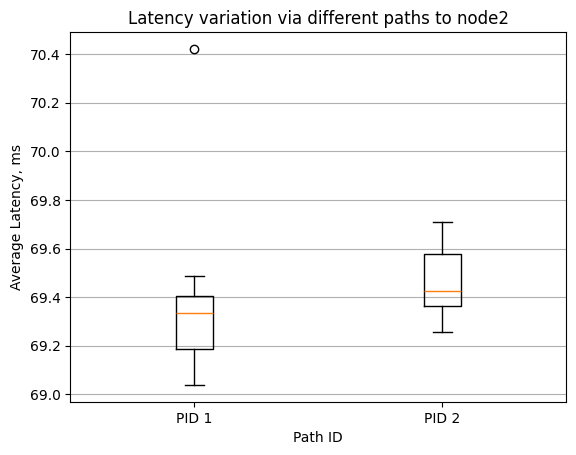

In [112]:
import matplotlib.pyplot as plt

# Example data
data21 = latency_variation2[0][1]
data22 = latency_variation2[1][1]

# Create a side-by-side box plot
plt.boxplot([data21, data22], labels=[f'PID {latency_variation2[0][0]}', f'PID {latency_variation2[1][0]}'])

# Add labels and title
plt.xlabel('Path ID')
plt.ylabel('Average Latency, ms')
plt.title('Latency variation via different paths to node2')
plt.grid(axis='y')
# Show the plot
plt.show()


In [101]:
latency_variation4 = []
path_ids_variation4 = []
path_number4 = 0
node1.execute("rm ping_node4.log")
for line in final_data:
    if line[1] == '42-ffaa:1:4':
        path_number4 += 1
        path_ids_variation4.append(line[0])
        
# pinging with different paths
for i in range(path_number4):
    node1.execute(f'echo {i} | /usr/local/scion/scion ping -c 10 42-ffaa:1:4,127.0.0.1 -i  > ping_node4.log 2>&1')
    stdout, stderr = node1.execute(f"cat ping_node4.log | grep 'time=' | awk -F'time=' '{{print $2}}' | awk -F'ms' '{{print $1}}'")
    ping_results4 = [float(item) for item in stdout.splitlines()]
    latency_variation4.append([path_ids_variation4[i], ping_results4])
print(latency_variation4)

22.016
21.911
21.867
21.909
21.781
22.038
22.008
22.030
22.031
22.002
61.173
61.123
61.089
61.139
61.183
61.272
60.849
61.084
61.073
60.933
152.628
152.594
152.612
152.565
152.566
152.487
152.484
152.538
152.521
152.644
[[5, [22.016, 21.911, 21.867, 21.909, 21.781, 22.038, 22.008, 22.03, 22.031, 22.002]], [6, [61.173, 61.123, 61.089, 61.139, 61.183, 61.272, 60.849, 61.084, 61.073, 60.933]], [7, [152.628, 152.594, 152.612, 152.565, 152.566, 152.487, 152.484, 152.538, 152.521, 152.644]]]


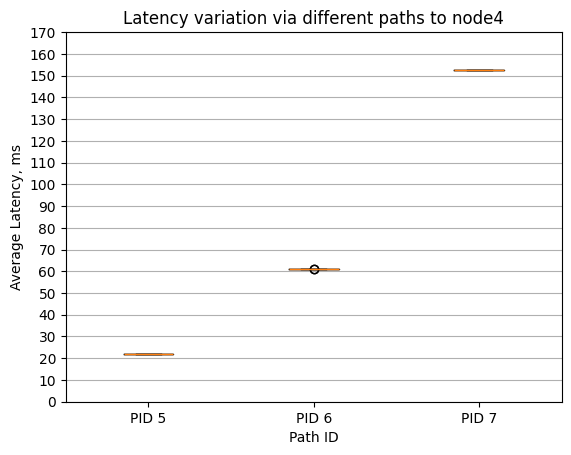

In [111]:
# Example data
data41 = latency_variation4[0][1]
data42 = latency_variation4[1][1]
data43 = latency_variation4[2][1]

# Create a side-by-side box plot
plt.boxplot([data41, data42, data43], labels=[f'PID {latency_variation4[0][0]}', f'PID {latency_variation4[1][0]}', f'PID {latency_variation4[2][0]}'])

# Add labels and title
plt.xlabel('Path ID')
plt.ylabel('Average Latency, ms')
plt.title('Latency variation via different paths to node4')
plt.grid(axis='y')

plt.yticks(range(0, 180, 10))

# Show the plot
plt.show()